In [112]:
!git clone https://github.com/enriqueesanchz/workoutAI.git

fatal: destination path 'workoutAI' already exists and is not an empty directory.


In [113]:
!rm workoutAI/data/csv/*_2.csv

rm: cannot remove 'workoutAI/data/csv/*_2.csv': No such file or directory


In [114]:
#Leo los archivos.csv
import os

actividades = []

for archivo in os.listdir('workoutAI/data/csv'):
  actividades.append(archivo)

print(actividades)

['remo_bajo.csv', 'press_sentado.csv', 'triceps_polea.csv', 'biceps_unilateral.csv', 'jalon_al_pecho.csv', 'jalon_unilateral.csv', 'press_inclinado.csv', 'press_militar.csv', 'triceps_unilateral.csv', 'biceps_martillo.csv']


In [115]:
import pandas as pd

In [116]:
import matplotlib.pyplot as plt
import numpy as np

def dibujar_clase(title, subset: pd.DataFrame):
  plt.figure(figsize=(20,2))
  plt.title(title)
  plt.plot(subset["accel_x"], label='accel_x')
  plt.plot(subset["accel_y"], label='accel_y')
  plt.plot(subset["accel_z"], label='accel_z')
  plt.legend()

  plt.figure(figsize=(20,2))
  plt.plot(subset["gyro_x"], label='gyro_x')
  plt.plot(subset["gyro_y"], label='gyro_y')
  plt.plot(subset["gyro_z"], label='gyro_z')
  plt.legend()

  # TODO: Otra manera interesante es replicar el mismo código pero usando las normas
  plt.figure(figsize=(20,2))
  plt.plot(np.linalg.norm(subset[['accel_x','accel_y','accel_z']].values,axis=1), label='accel norm')
  plt.legend()

  plt.figure(figsize=(20,2))
  plt.plot(np.linalg.norm(subset[['gyro_x','gyro_y','gyro_z']].values,axis=1), label='gyro norm')
  plt.legend()

  plt.show()

**Pasos a seguir:**
- Eliminamos el tiempo
- Eliminamos las primeras muestras
- Escogemos el eje con mayor std: el que más varía es donde mejor se ve la repetición
- Establecemos un umbral en ese eje
- Filtramos en un bucle para que no haya medidas repetidas

Tenemos la necesidad de establecer un criterio para el umbral:
Un porcentaje del máximo de un valor no puede serlo, puesto que si hay outliers no funciona bien.
- Método 1: Porcentaje del máximo: no funciona bien si hay outliers
- Método 2: Este umbral debe depender de la media/mediana y varianza
- Método 3: Percentil

# **Método 3: Percentil**

In [117]:
def get_percentil(subset: pd.DataFrame, num: float):
  serie_temporal = subset[max_std].values

  # Ordena la serie temporal
  sorted_data = np.sort(serie_temporal)

  # Calcula la posición del percentil 90
  position = num * (len(sorted_data) + 1)

  # Si la posición es un número entero, el percentil 90 es el valor en esa posición.
  # Si no es un número entero, interpola entre los valores adyacentes.
  if position.is_integer():
      percentil = sorted_data[int(position) - 1]
  else:
      lower_index = int(position)
      upper_index = lower_index + 1
      interpolation_factor = position - lower_index
      percentil = (1 - interpolation_factor) * sorted_data[lower_index - 1] + interpolation_factor * sorted_data[upper_index - 1]

  return percentil


In [118]:
# Ahora con todas las repeticiones
def dibuja_repes(titulo, subset, repeticiones):
  i = 0

  plt.figure(figsize=(20,2))
  plt.title(titulo)
  pincel1 = ['r', 'g', 'b']
  pincel2 = ['r:', 'g:', 'b:']
  pincel3 = ['ro', 'go', 'bo']
  contador = 0

  ventana = 40
  salto = 20

  while i + ventana < len(repeticiones):
    if(1 == repeticiones[i+15]):
      plt.plot(subset[max_std][i:i+ventana], pincel1[contador])
      plt.plot(range(100+i, 100+i+ventana), repeticiones[i:i+ventana], pincel2[contador])
      plt.plot(100+i, repeticiones[i], pincel3[contador])
      plt.plot(100+i+ventana-1, repeticiones[i+ventana], pincel3[contador])

      i = i + salto
      contador = (contador + 1) % 3

    else:
      i = i + 1

  plt.show()


In [119]:
# Ahora una encima de otra

def dibuja_repes_encima(titulo, subset, repeticiones):
  i = 0

  plt.figure(figsize=(6,7))
  plt.title(titulo)
  pincel1 = ['r', 'g', 'b']
  pincel2 = ['r:', 'g:', 'b:']
  pincel3 = ['ro', 'go', 'bo']
  contador = 0

  ventana = 30
  salto = 15

  while i + ventana < len(repeticiones):
    if(1 == repeticiones[i+15]):
      plt.plot(range(100, 100+ventana), subset[max_std][i:i+ventana], pincel1[contador % 3])

      i = i + salto
      contador = contador + 1

    else:
      i = i + 1

  plt.show()
  print("Eje:", max_std)
  print("Número de repeticiones:", contador)

# Podemos observar el patrón existente entre las diferentes repeticiones

In [120]:
for archivo in os.listdir('workoutAI/data/csv'):
  df = pd.read_csv(f"workoutAI/data/csv/{archivo}")

  skip = 100
  subset = df[skip:].drop('t', axis=1)
  dibujar_clase(archivo, subset)

Output hidden; open in https://colab.research.google.com to view.

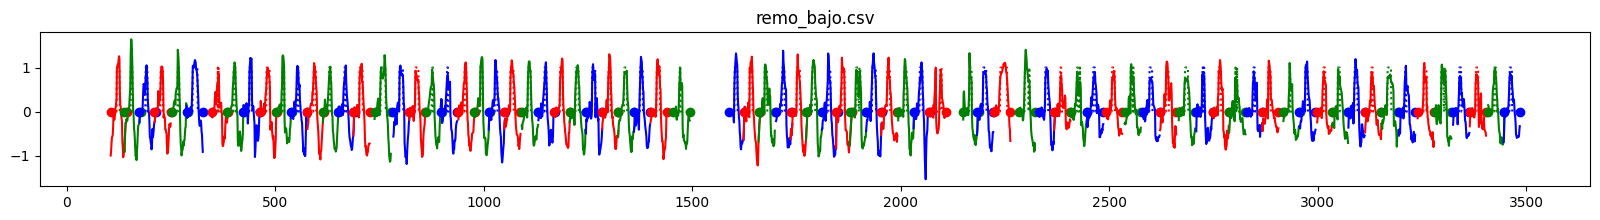

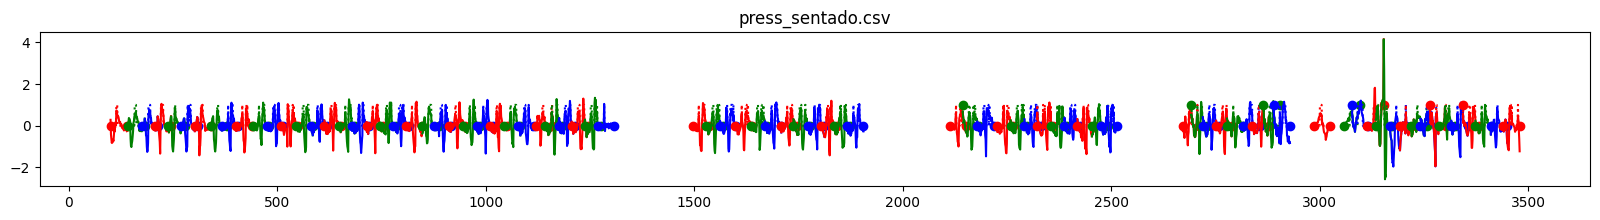

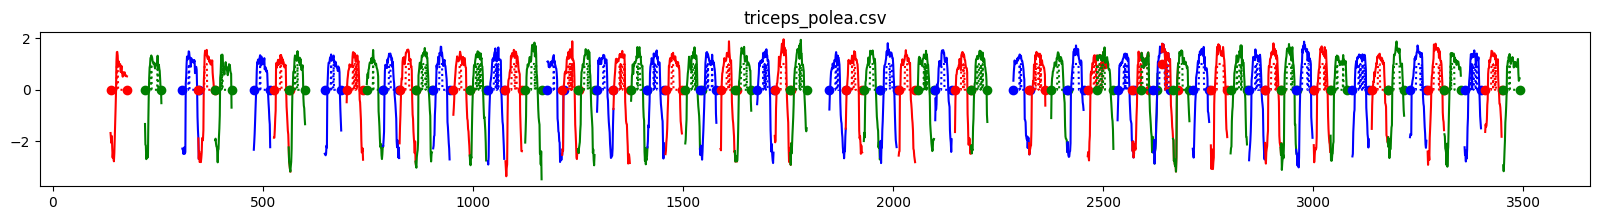

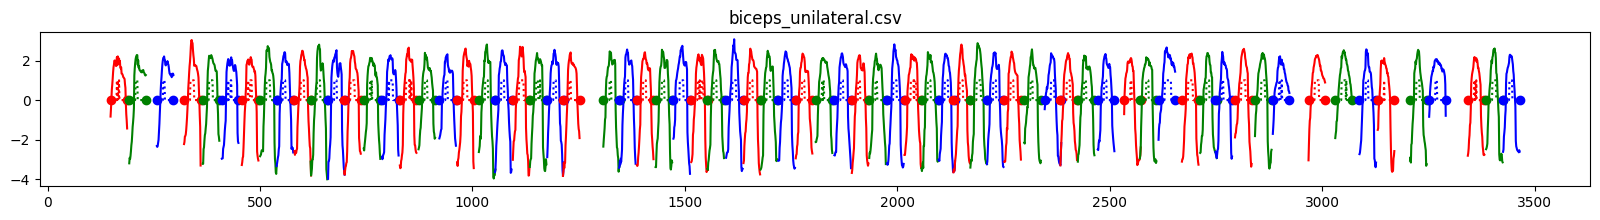

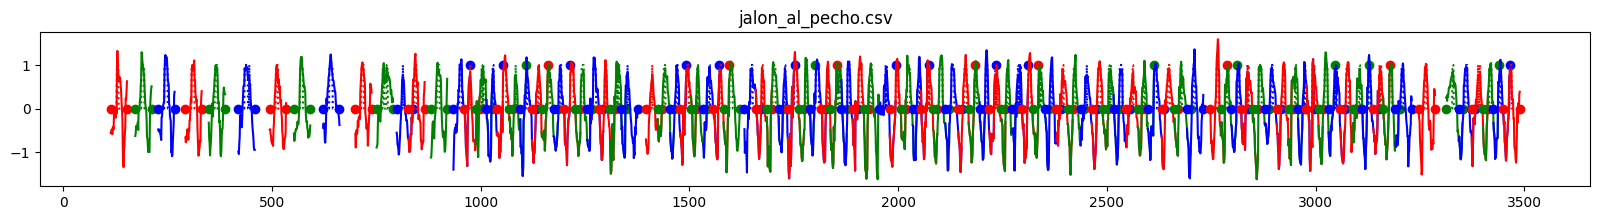

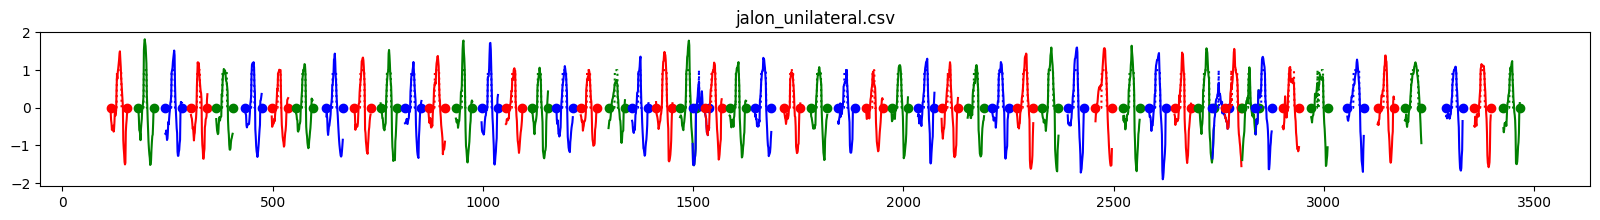

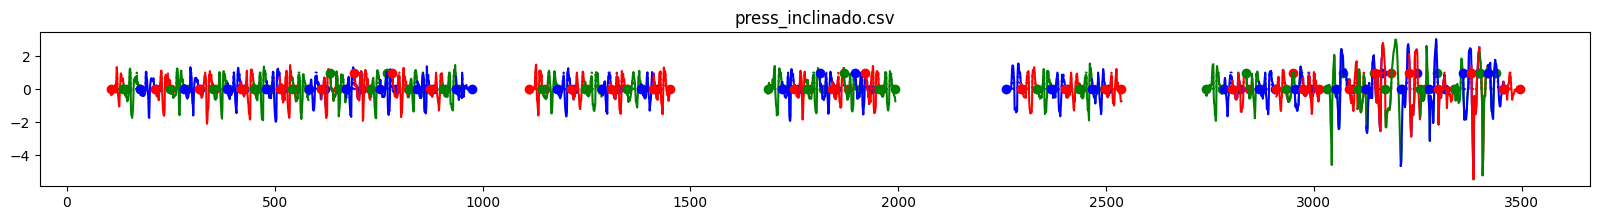

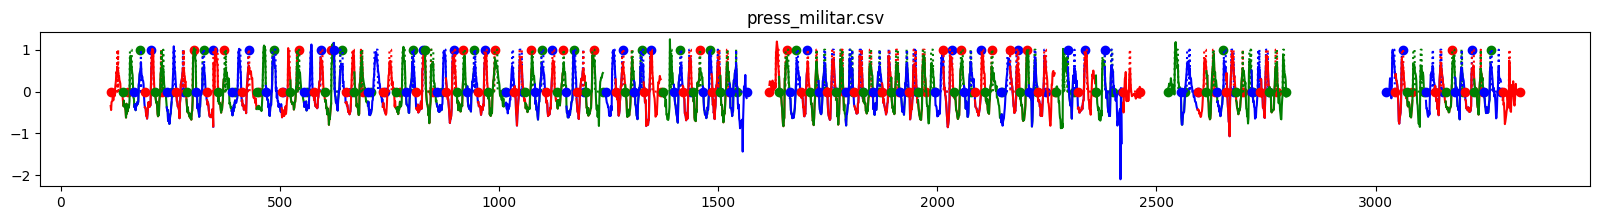

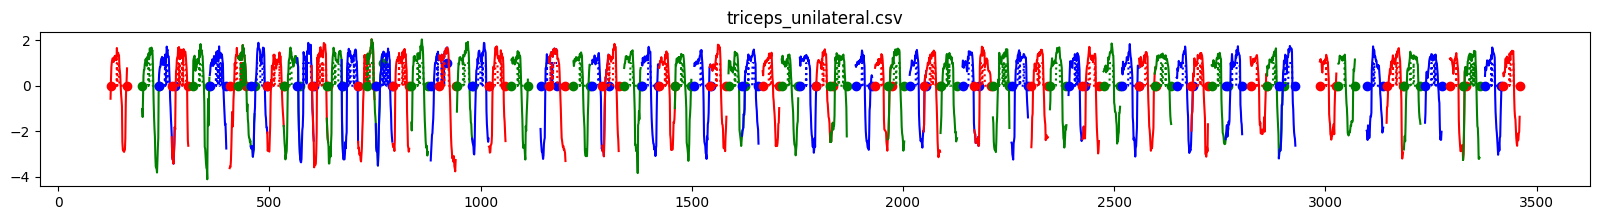

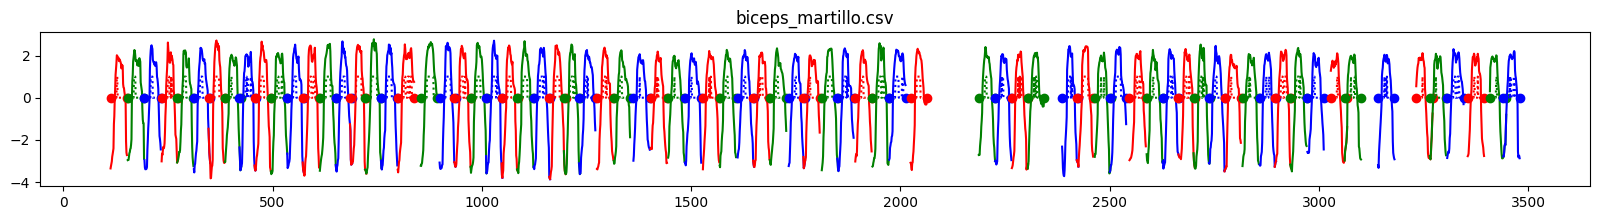

In [121]:
for archivo in os.listdir('workoutAI/data/csv'):
  df = pd.read_csv(f"workoutAI/data/csv/{archivo}")

  skip = 100
  subset = df[skip:].drop('t', axis=1)

  max_std = subset.std(axis=0).idxmax(axis=0)
  percentil_90 = get_percentil(subset, 0.85)

  umbral = percentil_90 #Metodo 3
  repeticiones = [1 if x > umbral else 0 for x in subset[max_std]]
  dibuja_repes(archivo, subset, repeticiones)

In [122]:
for archivo in os.listdir('workoutAI/data/csv'):
  df = pd.read_csv(f"workoutAI/data/csv/{archivo}")

  skip = 100
  subset = df[skip:].drop('t', axis=1)

  max_std = subset.std(axis=0).idxmax(axis=0)
  percentil_90 = get_percentil(subset, 0.90)

  umbral = percentil_90 #Metodo 3
  repeticiones = [1 if x > umbral else 0 for x in subset[max_std]]
  dibuja_repes_encima(archivo, subset, repeticiones)

Output hidden; open in https://colab.research.google.com to view.

In [123]:
import random

def create_segments_and_labels(ventana, salto, train, val):
  N_FEATURES = 6
  train_segments = []
  val_segments = []
  test_segments = []
  train_labels = []
  val_labels = []
  test_labels = []

  for archivo in os.listdir('workoutAI/data/csv'):
    segments = []
    labels = []

    df = pd.read_csv(f"workoutAI/data/csv/{archivo}")

    skip = 100

    subset = df[skip:].drop('t', axis=1)

    max_std = subset.std(axis=0).idxmax(axis=0)
    percentil_90 = get_percentil(subset, 0.90)

    print(percentil_90)

    umbral = percentil_90 #Metodo 3
    repeticiones = [1 if x > umbral else 0 for x in subset[max_std]]

    i = 0
    while i + ventana < len(repeticiones):
      if(1 == repeticiones[i+15]):
        accel_xs = subset['accel_x'].values[i: i + ventana]
        accel_ys = subset['accel_y'].values[i: i + ventana]
        accel_zs = subset['accel_z'].values[i: i + ventana]
        gyro_xs = subset['gyro_x'].values[i: i + ventana]
        gyro_ys = subset['gyro_y'].values[i: i + ventana]
        gyro_zs = subset['gyro_z'].values[i: i + ventana]

        # Lo etiquetamos como la actividad más frecuente
        segments.append([accel_xs, accel_ys, accel_zs, gyro_xs, gyro_ys, gyro_zs])
        labels.append(archivo)

        i = i + salto
      else:
        i = i + 1

    random.shuffle(segments)

    train_len = int(0.7*len(segments))
    val_len = train_len + int(0.2*len(segments))

    train_segments.extend(segments[:train_len])
    val_segments.extend(segments[train_len:val_len])
    test_segments.extend(segments[val_len:])

    train_labels.extend(labels[:train_len])
    val_labels.extend(labels[train_len:val_len])
    test_labels.extend(labels[val_len:])

  # Los pasamos a vector
  train_segments = np.asarray(train_segments, dtype= np.float32).reshape(-1, ventana, N_FEATURES)
  val_segments = np.asarray(val_segments, dtype= np.float32).reshape(-1, ventana, N_FEATURES)
  test_segments = np.asarray(test_segments, dtype= np.float32).reshape(-1, ventana, N_FEATURES)

  train_labels = np.asarray(train_labels)
  val_labels = np.asarray(val_labels)
  test_labels = np.asarray(test_labels)

  return train_segments, train_labels, val_segments, val_labels, test_segments, test_labels


In [124]:
x_train, y_train, x_val, y_val, x_test, y_test = create_segments_and_labels(30, 20, 0.7, 0.2)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)
print(set(y_train))
print(set(y_val))
print(set(y_test))

0.58577339053154
0.6036373972892762
0.6930595159530641
0.27538554668426507
0.8640657663345337
0.7105020701885224
0.9028997004032137
0.6088253915309906
1.4137942790985107
2.0956747770309443
(628, 30, 6)
(628,)
(176, 30, 6)
(176,)
(101, 30, 6)
(101,)
{'jalon_al_pecho.csv', 'triceps_unilateral.csv', 'jalon_unilateral.csv', 'remo_bajo.csv', 'press_militar.csv', 'biceps_unilateral.csv', 'press_sentado.csv', 'triceps_polea.csv', 'biceps_martillo.csv', 'press_inclinado.csv'}
{'jalon_al_pecho.csv', 'triceps_unilateral.csv', 'jalon_unilateral.csv', 'remo_bajo.csv', 'press_militar.csv', 'biceps_unilateral.csv', 'press_sentado.csv', 'triceps_polea.csv', 'biceps_martillo.csv', 'press_inclinado.csv'}
{'jalon_al_pecho.csv', 'triceps_unilateral.csv', 'jalon_unilateral.csv', 'remo_bajo.csv', 'press_militar.csv', 'biceps_unilateral.csv', 'press_sentado.csv', 'triceps_polea.csv', 'biceps_martillo.csv', 'press_inclinado.csv'}


In [125]:
#%% Normalizamos los datos
#TODO: probar diferentes normalizaciones

# Supongamos que tu conjunto de datos se llama 'data'
# 'data' debe tener la forma (627, 40, 6)

# Reshape para tener una forma de (627*40, 6)
data_reshaped = x_train.reshape(-1, 6)

# Calcula la media y la desviación estándar para cada característica
mean_values = np.mean(data_reshaped, axis=0)
std_dev_values = np.std(data_reshaped, axis=0)

# Aplica la normalización Z-score
standardized_data = (data_reshaped - mean_values) / std_dev_values

# Reshape de vuelta a la forma original
x_train = standardized_data.reshape(x_train.shape)


# Supongamos que tu conjunto de datos se llama 'data'
# 'data' debe tener la forma (627, 40, 6)

# Reshape para tener una forma de (627*40, 6)
data_reshaped = x_val.reshape(-1, 6)

# Calcula la media y la desviación estándar para cada característica
mean_values = np.mean(data_reshaped, axis=0)
std_dev_values = np.std(data_reshaped, axis=0)

# Aplica la normalización Z-score
standardized_data = (data_reshaped - mean_values) / std_dev_values

# Reshape de vuelta a la forma original
x_val = standardized_data.reshape(x_val.shape)


# Supongamos que tu conjunto de datos se llama 'data'
# 'data' debe tener la forma (627, 40, 6)

# Reshape para tener una forma de (627*40, 6)
data_reshaped = x_test.reshape(-1, 6)

# Calcula la media y la desviación estándar para cada característica
mean_values = np.mean(data_reshaped, axis=0)
std_dev_values = np.std(data_reshaped, axis=0)

# Aplica la normalización Z-score
standardized_data = (data_reshaped - mean_values) / std_dev_values

# Reshape de vuelta a la forma original
x_test = standardized_data.reshape(x_test.shape)


x_train[:,:,0]

array([[-0.7491528 , -0.7823862 , -0.9837804 , ...,  0.24469207,
         1.3151162 , -0.17928308],
       [-0.88042456, -0.87012225, -1.2795572 , ...,  0.15444908,
         1.0209047 , -0.51667356],
       [-0.73951524, -0.90169394, -1.1379831 , ..., -0.4269674 ,
         1.0246643 , -0.02396483],
       ...,
       [ 1.3266146 , -0.24699685, -0.29252654, ...,  2.2864256 ,
         2.3246698 ,  2.1992455 ],
       [-0.37062493, -0.18651214,  0.6910683 , ...,  2.605949  ,
         1.8003552 , -0.84547997],
       [ 0.5621311 , -0.5856447 , -0.16690448, ...,  2.55866   ,
         2.7601616 ,  2.2625766 ]], dtype=float32)

In [126]:
#%% transformamos los datos a flotantes

x_train = x_train.astype('float32')
#y_train = y_train.astype('float32')

x_val = x_val.astype('float32')
#y_train = y_train.astype('float32')

x_test = x_test.astype('float32')
#y_test = y_test.astype('float32')

In [127]:
#%% Realizamos el one-hote econding para los datos de salida

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
y_train_hot = cat_encoder.fit_transform(y_train.reshape(len(y_train),1))
y_train = y_train_hot.toarray()

y_val_hot = cat_encoder.fit_transform(y_val.reshape(len(y_val),1))
y_val = y_val_hot.toarray()

In [128]:
#%% RED NEURONAL

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv1D, MaxPool1D, Flatten

epochs = 10
batch_size = 40
filters = 16
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]

model_m = Sequential()
model_m.add(Conv1D(filters=filters, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
#model_m.add(Conv1D(filters=filters/2, kernel_size=5, activation='relu'))
model_m.add(Dropout(0.5))
model_m.add(MaxPool1D(pool_size=2))
model_m.add(Flatten())
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(n_outputs, activation='softmax'))
model_m.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 26, 16)            496       
                                                                 
 dropout_16 (Dropout)        (None, 26, 16)            0         
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 13, 16)            0         
 ng1D)                                                           
                                                                 
 flatten_16 (Flatten)        (None, 208)               0         
                                                                 
 dense_29 (Dense)            (None, 100)               20900     
                                                                 
 dense_30 (Dense)            (None, 10)                1010      
                                                     

In [129]:
#%% Compilamps el modelo y entrenamos

from tensorflow.keras import callbacks

model_m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks_list = [
    callbacks.ModelCheckpoint(
        filepath='best_model_padel.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    #callbacks.EarlyStopping(monitor='accuracy', patience=20)
]

print(x_train.shape)

# fit network
history = model_m.fit(x_train,
                      y_train,
                      batch_size=batch_size,
                      validation_data=(x_val, y_val),
                      shuffle=True,
                      epochs=epochs,
                      verbose=1,
                      callbacks=callbacks_list)

(628, 30, 6)
Epoch 1/10
16/16 [==============================] - 1s 19ms/step - loss: 2.1363 - accuracy: 0.2038 - val_loss: 1.6503 - val_accuracy: 0.4432
Epoch 2/10
16/16 [==============================] - 0s 6ms/step - loss: 1.4103 - accuracy: 0.5398 - val_loss: 1.0987 - val_accuracy: 0.8693
Epoch 3/10
 1/16 [>.............................] - ETA: 0s - loss: 0.9631 - accuracy: 0.7750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 7ms/step - loss: 0.8752 - accuracy: 0.7850 - val_loss: 0.6077 - val_accuracy: 0.9205
Epoch 4/10
16/16 [==============================] - 0s 6ms/step - loss: 0.5053 - accuracy: 0.8869 - val_loss: 0.3361 - val_accuracy: 0.9659
Epoch 5/10
16/16 [==============================] - 0s 7ms/step - loss: 0.3285 - accuracy: 0.9076 - val_loss: 0.2098 - val_accuracy: 0.9716
Epoch 6/10
16/16 [==============================] - 0s 7ms/step - loss: 0.2206 - accuracy: 0.9570 - val_loss: 0.1434 - val_accuracy: 0.9830
Epoch 7/10
16/16 [==============================] - 0s 7ms/step - loss: 0.1762 - accuracy: 0.9634 - val_loss: 0.1133 - val_accuracy: 0.9886
Epoch 8/10
16/16 [==============================] - 0s 6ms/step - loss: 0.1045 - accuracy: 0.9889 - val_loss: 0.0902 - val_accuracy: 0.9830
Epoch 9/10
16/16 [==============================] - 0s 6ms/step - loss: 0.1012 - accuracy: 0.9777 - val_loss: 0.0712 - val_accuracy: 0.9886
Epoch 10/10
16/16 [============

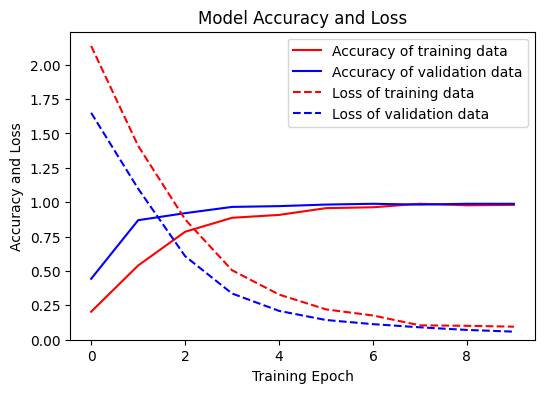

In [130]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


In [131]:
# actualizar dependiendo del nombre del modelo guardado
y_test_hot = cat_encoder.fit_transform(y_test.reshape(len(y_test),1))
y_test = y_test_hot.toarray()

In [132]:
#%% Evaluamos el modelo en los datos de test
test_loss, test_acc = model_m.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

4/4 [==============================] - 0s 3ms/step - loss: 0.0555 - accuracy: 0.9901
Test accuracy 0.9900990128517151
Test loss 0.055454522371292114


In [133]:
#%%
from sklearn.metrics import classification_report

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
max_y_train = np.argmax(y_train, axis=1)
print(classification_report(max_y_train, max_y_pred_train))

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00        65
           3       1.00      1.00      1.00        37
           4       0.98      1.00      0.99        53
           5       1.00      1.00      1.00        68
           6       1.00      0.98      0.99        56
           7       1.00      1.00      1.00        56
           8       1.00      1.00      1.00       102
           9       0.98      0.98      0.98        47

    accuracy                           1.00       628
   macro avg       1.00      1.00      1.00       628
weighted avg       1.00      1.00      1.00       628



4/4 [==============================] - 0s 3ms/step


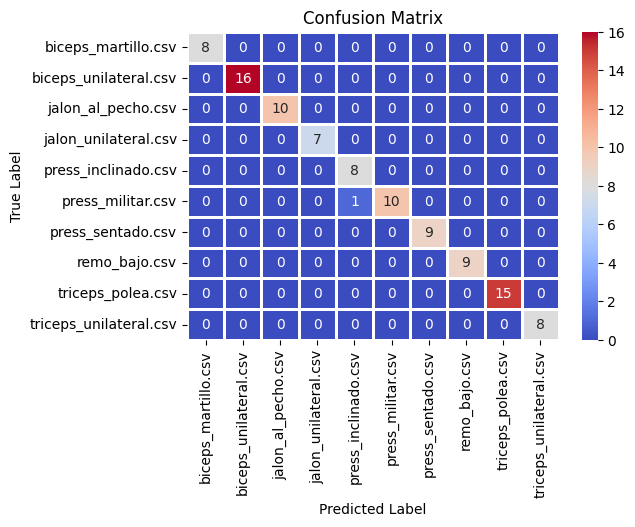

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         7
           4       0.89      1.00      0.94         8
           5       1.00      0.91      0.95        11
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         9
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00         8

    accuracy                           0.99       101
   macro avg       0.99      0.99      0.99       101
weighted avg       0.99      0.99      0.99       101



In [134]:
#%%
from sklearn import metrics
plt.rcParams.update(plt.rcParamsDefault)

LABELS = actividades
LABELS.sort()

def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)
# Toma la clase con la mayor probabilidad a partir de las predicciones de la prueba
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))